# Sirius B ADI Analysis

## Imports

In [1]:
from os.path import join
import sys

import numpy as np
import matplotlib.pyplot as plt
import vip_hci as vip
from vip_hci.conf.param import KECK_NIRC2
from hciplot import plot_frames
import tqdm.auto as tqdm

sys.path.append("../src")

import paths

plt.style.use(["fivethirtyeight", "seaborn-notebook"])
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
ds9 = vip.Ds9Window()

## Load Data

In [3]:
full_cube = vip.fits.open_fits(join(paths.output, "sirius-b_cube.fits"))
full_angles = vip.fits.open_fits(join(paths.output, "sirius-b_pa.fits"))

cube = np.delete(full_cube, slice(80, 131), 0)
angles = np.delete(full_angles, slice(80, 131), 0)

Fits HDU-0 data successfully loaded. Data shape: (205, 256, 256)
Fits HDU-0 data successfully loaded. Data shape: (205,)


In [46]:
ds9.display(cube)

## Generating PSF

Now I'm going to build a PSF model from our cube. Since there is no coronagraphic data, if we just combine the cube without derotating, we should get a pretty good model of the PSF. From this, we'll do a tiny bit of background subtraction via median filtering.

In [5]:
psf = vip.metrics.collapse_psf_cube(cube, 64, fwhm=8.41)

New shape: (154, 64, 64)
`Force_odd` is True therefore `size` was set to 65
Flux in 1xFWHM aperture: 1912745.838
Done scaled PSF template from the average of 154 frames.


In [45]:
ds9.display(psf)

In [6]:
# see if median filtering does anything
from scipy.ndimage import median_filter

psf_filt, _, fwhm = vip.metrics.normalize_psf(
    median_filter(psf, 3, mode="constant"), model="airy", full_output=True
)

`Force_odd` is True and frame size is even, therefore new frame size was set to 63
FWHM: 8.416
Flux in 1xFWHM aperture: 0.979


In [14]:
ds9.display(psf, psf_filt)

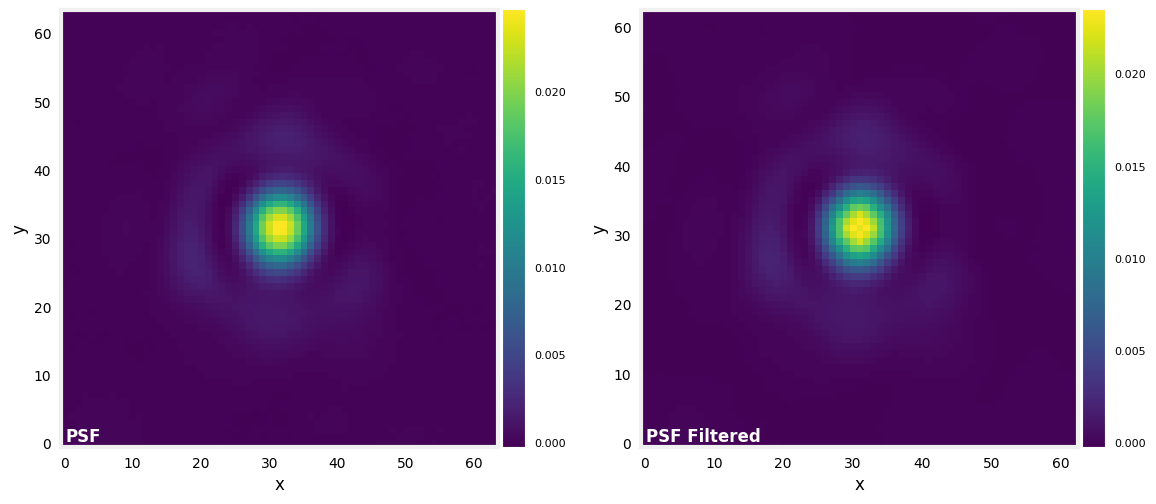

In [8]:
plot_frames((psf, psf_filt), label=("PSF", "PSF Filtered"), horsp=0.25)

In [9]:
vip.fits.write_fits(join(paths.output, "sirius-b_psf.fits"), psf_filt)

Fits file successfully saved


## ADI Methods (that I didn't end up using)

### Median Subtraction

In [38]:
res_med = vip.medsub.median_sub(cube, angles)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-03 12:25:53
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.922687
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [29]:
ds9.display(res_med)

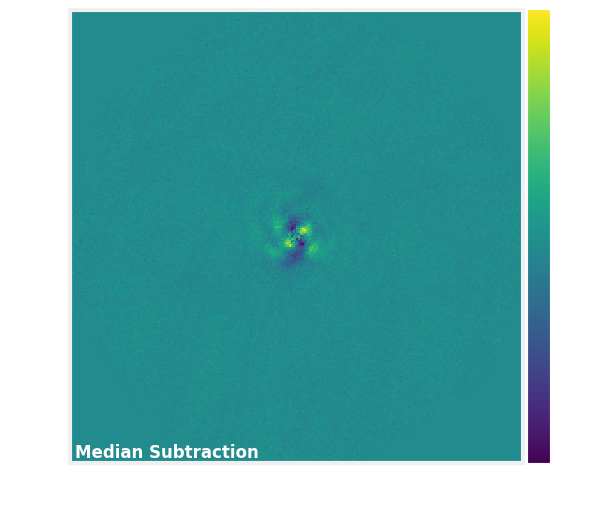

In [58]:
plot_frames(res_med, label="Median Subtraction")

### Pairwise Frame Differencing

In [41]:
res_frdiff = vip.frdiff.frame_diff(cube, angles, fwhm, radius_int=4, asize=8)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-03 12:26:16
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
15 annuli. Performing pair-wise subtraction:
PA threshold 31.53 is too big, will be set to 27.06
Ann 1    PA thresh: 27.06    Ann center:   8    N segments: 1 
Ann 2    PA thresh: 16.07    Ann center:  16    N segments: 1 
Ann 3    PA thresh: 10.75    Ann center:  24    N segments: 1 
Ann 4    PA thresh:  8.07    Ann center:  32    N segments: 1 
Ann 5    PA thresh:  6.46    Ann center:  40    N segments: 1 
Ann 6    PA thresh:  5.39    Ann center:  48    N segments: 1 
Ann 7    PA thresh:  4.62    Ann center:  56    N segments: 1 
Ann 8    PA thresh:  4.04    Ann center:  64    N segments: 1 
Ann 9    PA thresh:  3.59    Ann center:  72    N segments: 1 
Ann 10    PA thresh:  3.23    Ann center:  80    N segments: 1 
Ann 11    PA thresh:  2.94    Ann center:  88    N segments: 1 
Ann 12    P

In [59]:
ds9.display(res_frdiff)

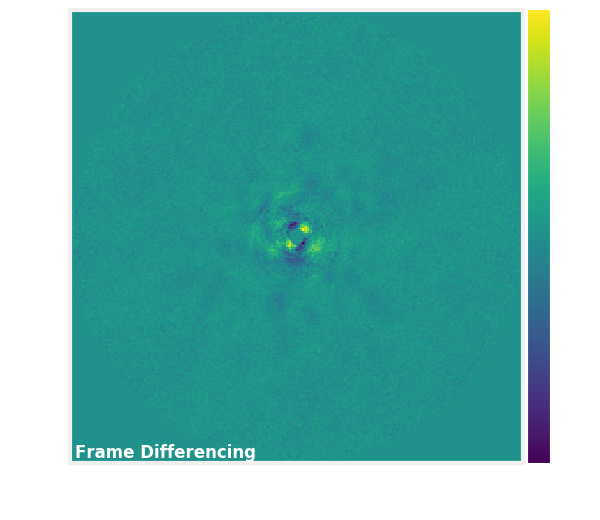

In [60]:
plot_frames(res_frdiff, label="Frame Differencing")

### LOCI

In [42]:
res_loci = vip.leastsq.xloci(
    cube,
    angles,
    fwhm=fwhm,
    asize=8,
    dist_threshold=90,
    delta_rot=0.2,
    optim_scale_fact=2,
)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-03 12:26:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Building 16 annuli:
Ann 1    PA thresh: 25.45    Ann center:   4    N segments: 4 
Ann 2    PA thresh:  8.61    Ann center:  12    N segments: 4 
Ann 3    PA thresh:  5.17    Ann center:  20    N segments: 4 
Ann 4    PA thresh:  3.70    Ann center:  28    N segments: 4 
Ann 5    PA thresh:  2.88    Ann center:  36    N segments: 4 
Ann 6    PA thresh:  2.35    Ann center:  44    N segments: 4 
Ann 7    PA thresh:  1.99    Ann center:  52    N segments: 4 
Ann 8    PA thresh:  1.73    Ann center:  60    N segments: 4 
Ann 9    PA thresh:  1.52    Ann center:  68    N segments: 4 
Ann 10    PA thresh:  1.36    Ann center:  76    N segments: 4 
Ann 11    PA thresh:  1.23    Ann center:  84    N segments: 4 
Ann 12    PA thresh:  1.13    Ann center:  92    N segments: 4 
Ann 13    PA thresh:  1.

In [ ]:
ds9.display(res_loci)

/Users/miles/.pyenv/versions/3.7.4/Python.framework/Versions/3.7/lib/python3.7/site-packages/hciplot/hciplot.py:398: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = subplot(rows, cols, v)


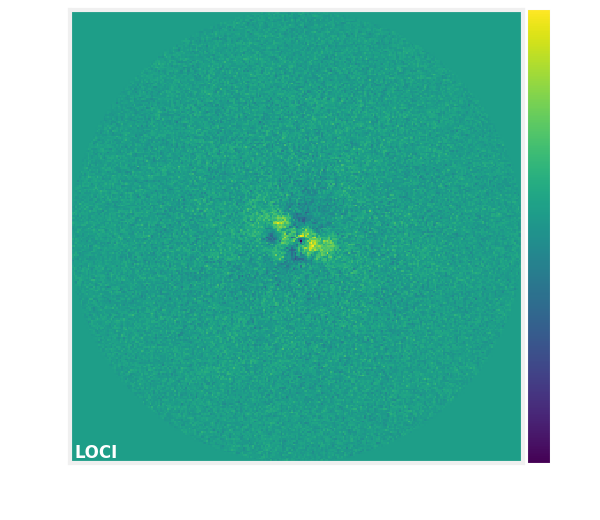

In [62]:
plot_frames(res_loci, label="LOCI")

### PCA Fake RDI

In [16]:
res_pca_rdi = np.array(
    [
        mask_circle(
            pca(full_cube, full_angles, cube_ref=cube, ncomp=i, nproc=4, verbose=False),
            fwhm,
        )
        for i in tqdm.tnrange(1, 26)
    ]
)

In [37]:
ds9.display(*res_pca_rdi)

### Annular PCA

In [69]:
from vip_hci.pca import pca_annular


res_pca_ann = pca_annular(cube, angles, fwhm=fwhm, asize=4, nproc=4, ncomp=50)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-03 11:29:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 32, FWHM = 8.416
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 23.76    Ann center:   2    N segments: 1 
Ann 2    PA thresh: 10.34    Ann center:   6    N segments: 1 
Ann 3    PA thresh:  7.61    Ann center:  10    N segments: 1 
Ann 4    PA thresh:  6.44    Ann center:  14    N segments: 1 


KeyboardInterrupt: 

In [38]:
ds9.display(*res_pca_ann

In [ ]:
plot_frames(res_pca_ann)

In [34]:
fr_pca_auto = vip.pca.pca_annular(
    cube,
    angles,
    fwhm=fwhm,
    ncomp="auto",
    svd_mode="lapack",
    asize=8,
    delta_rot=0.5,
    n_segments=3,
    tol=0.1,
    verbose=True,
)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-03 12:09:54
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 16, FWHM = 9.034
PCA per annulus (or annular sectors):
PA threshold 58.90 is too big, will be set to 27.06
Ann 1    PA thresh: 27.06    Ann center:   4    N segments: 3 
Ann 2    PA thresh: 21.32    Ann center:  12    N segments: 3 
Ann 3    PA thresh: 12.89    Ann center:  20    N segments: 3 
Ann 4    PA thresh:  9.22    Ann center:  28    N segments: 3 
Ann 5    PA thresh:  7.18    Ann center:  36    N segments: 3 
Ann 6    PA thresh:  5.88    Ann center:  44    N segments: 3 
Ann 7    PA thresh:  4.97    Ann center:  52    N segments: 3 
Ann 8    PA thresh:  4.31    Ann center:  60    N segments: 3 
Ann 9    PA thresh:  3.80    Ann center:  68    N segments: 3 
Ann 10    PA thresh:  3.40    Ann center:  76    N segments: 3 
Ann 11    PA thresh:  3.08    Ann center:  84    N seg

In [35]:
ds9.display(fr_pca_auto)

/Users/miles/.pyenv/versions/3.7.4/Python.framework/Versions/3.7/lib/python3.7/site-packages/hciplot/hciplot.py:398: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = subplot(rows, cols, v)


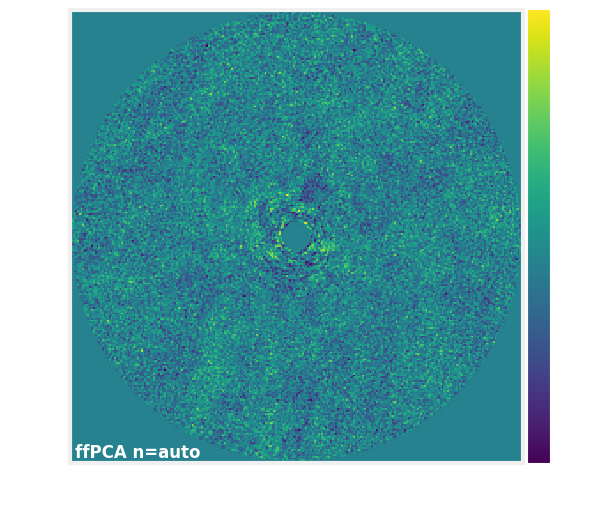

In [36]:
plot_frames(fr_pca_auto, label="ffPCA n=auto")

### NMF

In [6]:
res_nmf = np.array(
    [vip.nmf.nmf(cube, angles, ncomp=i, verbose=False) for i in tqdm.tnrange(1, 76, 3)]
)

In [52]:
ds9.display(*res_nmf)

In [23]:
res_nmf_masked = np.array(
    [
        vip.nmf.nmf(vip.var.mask_circle(cube, fwhm / 2), angles, ncomp=i, verbose=False)
        for i in tqdm.tnrange(1, 76, 15)
    ]
)

In [53]:
ds9.display(*res_nmf_masked)

### LLSG

In [32]:
res_llsg = vip.llsg.llsg(cube, angles, fwhm, rank=6)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-03 12:07:54
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Annuli = 6
Processing annulus: 
1 : in_rad=0, n_segm=4
2 : in_rad=19, n_segm=4
3 : in_rad=38, n_segm=4
4 : in_rad=57, n_segm=4
5 : in_rad=76, n_segm=4
6 : in_rad=95, n_segm=4

Running time:  0:00:07.372814
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [26]:
ds9.display(res_llsg)

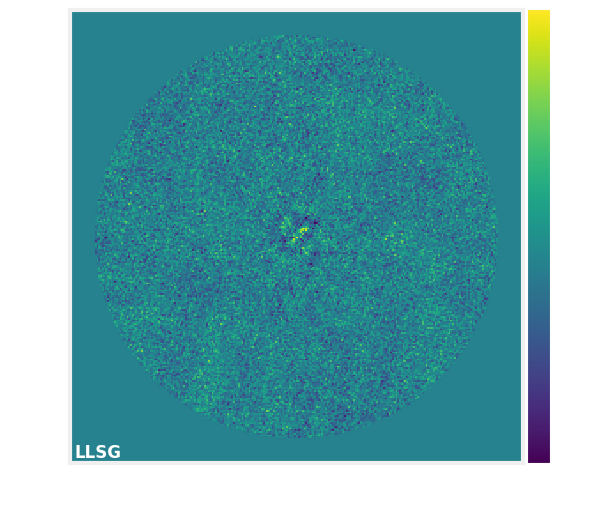

In [33]:
plot_frames(res_llsg, label="LLSG")

## Full Frame PCA

In [16]:
res_pca = vip.pca.pca(cube, angles, fwhm=fwhm, ncomp=(1, 50))

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-05 19:35:49
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 5.886 GB
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:01.008720
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Computed residual frames for PCs interval: (1, 50)
Number of steps 50
Running time:  0:00:32.581781
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


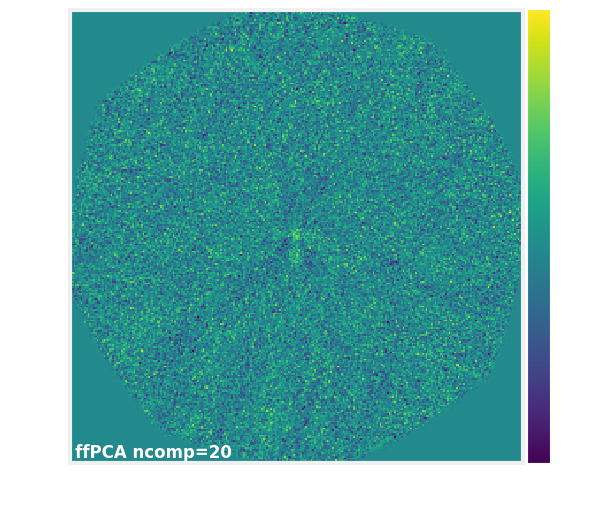

In [11]:
plot_frames(res_pca, label="ffPCA ncomp=20")

In [20]:
ds9.display(res_pca)

In [26]:
res_pca_mask = vip.pca.pca(cube, angles, fwhm=fwhm, ncomp=(1, 50), mask_center_px=7)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-05 20:18:18
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 5.510 GB
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:01.120179
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Computed residual frames for PCs interval: (1, 50)
Number of steps 50
Running time:  0:00:32.455030
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [ ]:
ds9.display(res_pca_mask)

Here I've noticed a "blob" showing up in DS9, so I'll try re-running the VIP PCA routine which will optimize the number of components based on the SNR of the location.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-09 11:11:34
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 5.473 GB
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:01.238105
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Number of steps 50
Optimal number of PCs = 27, for S/N=2.884
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 127.0, 113.0
Flux in a centered 1xFWHM circular aperture = 705.257
Central pixel S/N = 5.779
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 2.884
Max S/N (shifting the aperture center) = 5.811
stddev S/N (shifting the aperture center) = 1.263



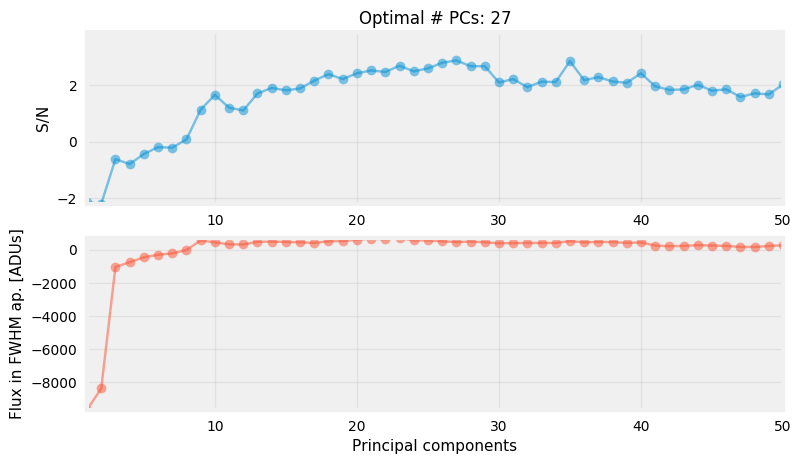

In [43]:
res_pca_mask_opt = vip.pca.pca(
    cube, angles, fwhm=fwhm, ncomp=(1, 50), source_xy=(127, 113), mask_center_px=7
)

In [47]:
ds9.display(res_pca_mask_opt)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-05 20:08:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


/Users/miles/.pyenv/versions/3.7.4/Python.framework/Versions/3.7/lib/python3.7/site-packages/hciplot/hciplot.py:398: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = subplot(rows, cols, v)


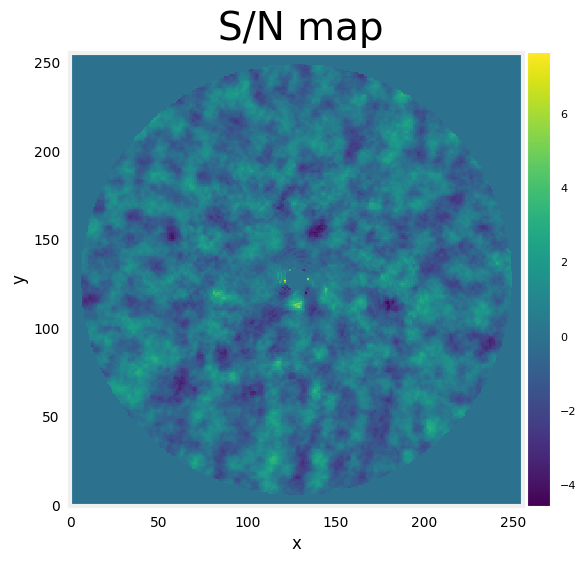

S/N map created using 4 processes
Running time:  0:00:59.890442
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [23]:
pca_snr_map = vip.metrics.snrmap(res_pca_mask_opt, fwhm, plot=True);

In [24]:
ds9.display(pca_snr_map)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2020-04-05 20:47:59
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 8.41606866639329, # BRANCHES = 1, SIGMA = 5, STARPHOT = 1912745
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Finished the throughput calculation
Running time:  0:00:15.586236
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


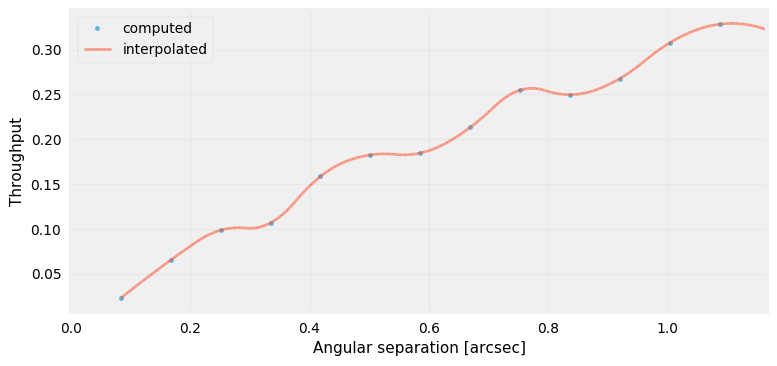

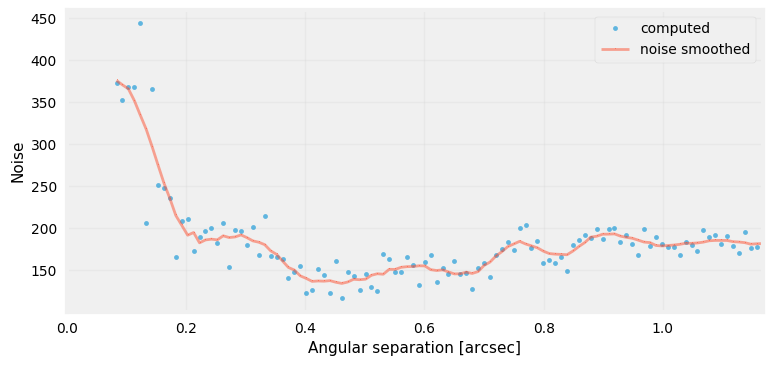

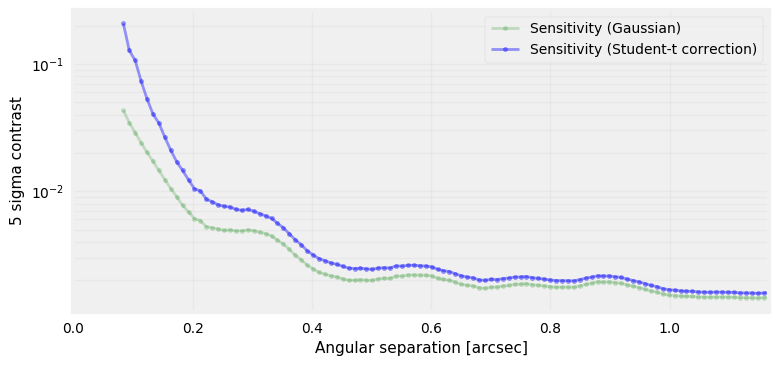

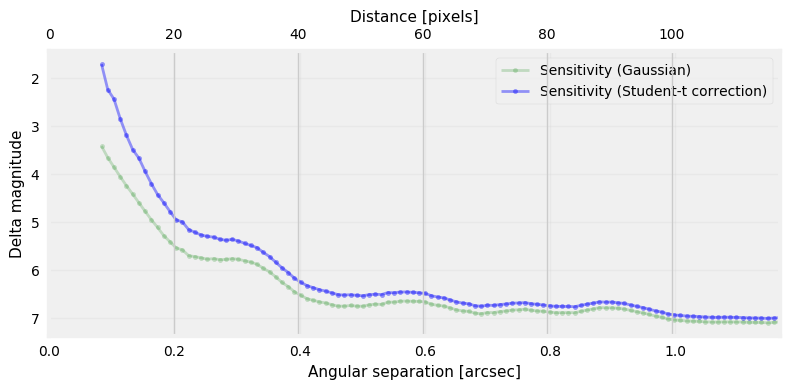

In [12]:
cc = vip.metrics.contrast_curve(
    cube,
    angles,
    psf_filt,
    fwhm=fwhm,
    pxscale=KECK_NIRC2["plsc_narrow"],
    sigma=5,
    algo=vip.pca.pca,
    ncomp=27,
    starphot=1912745,  # from our PSF creation in first section
    debug=True,
)
plt.tight_layout()

## Mosaic

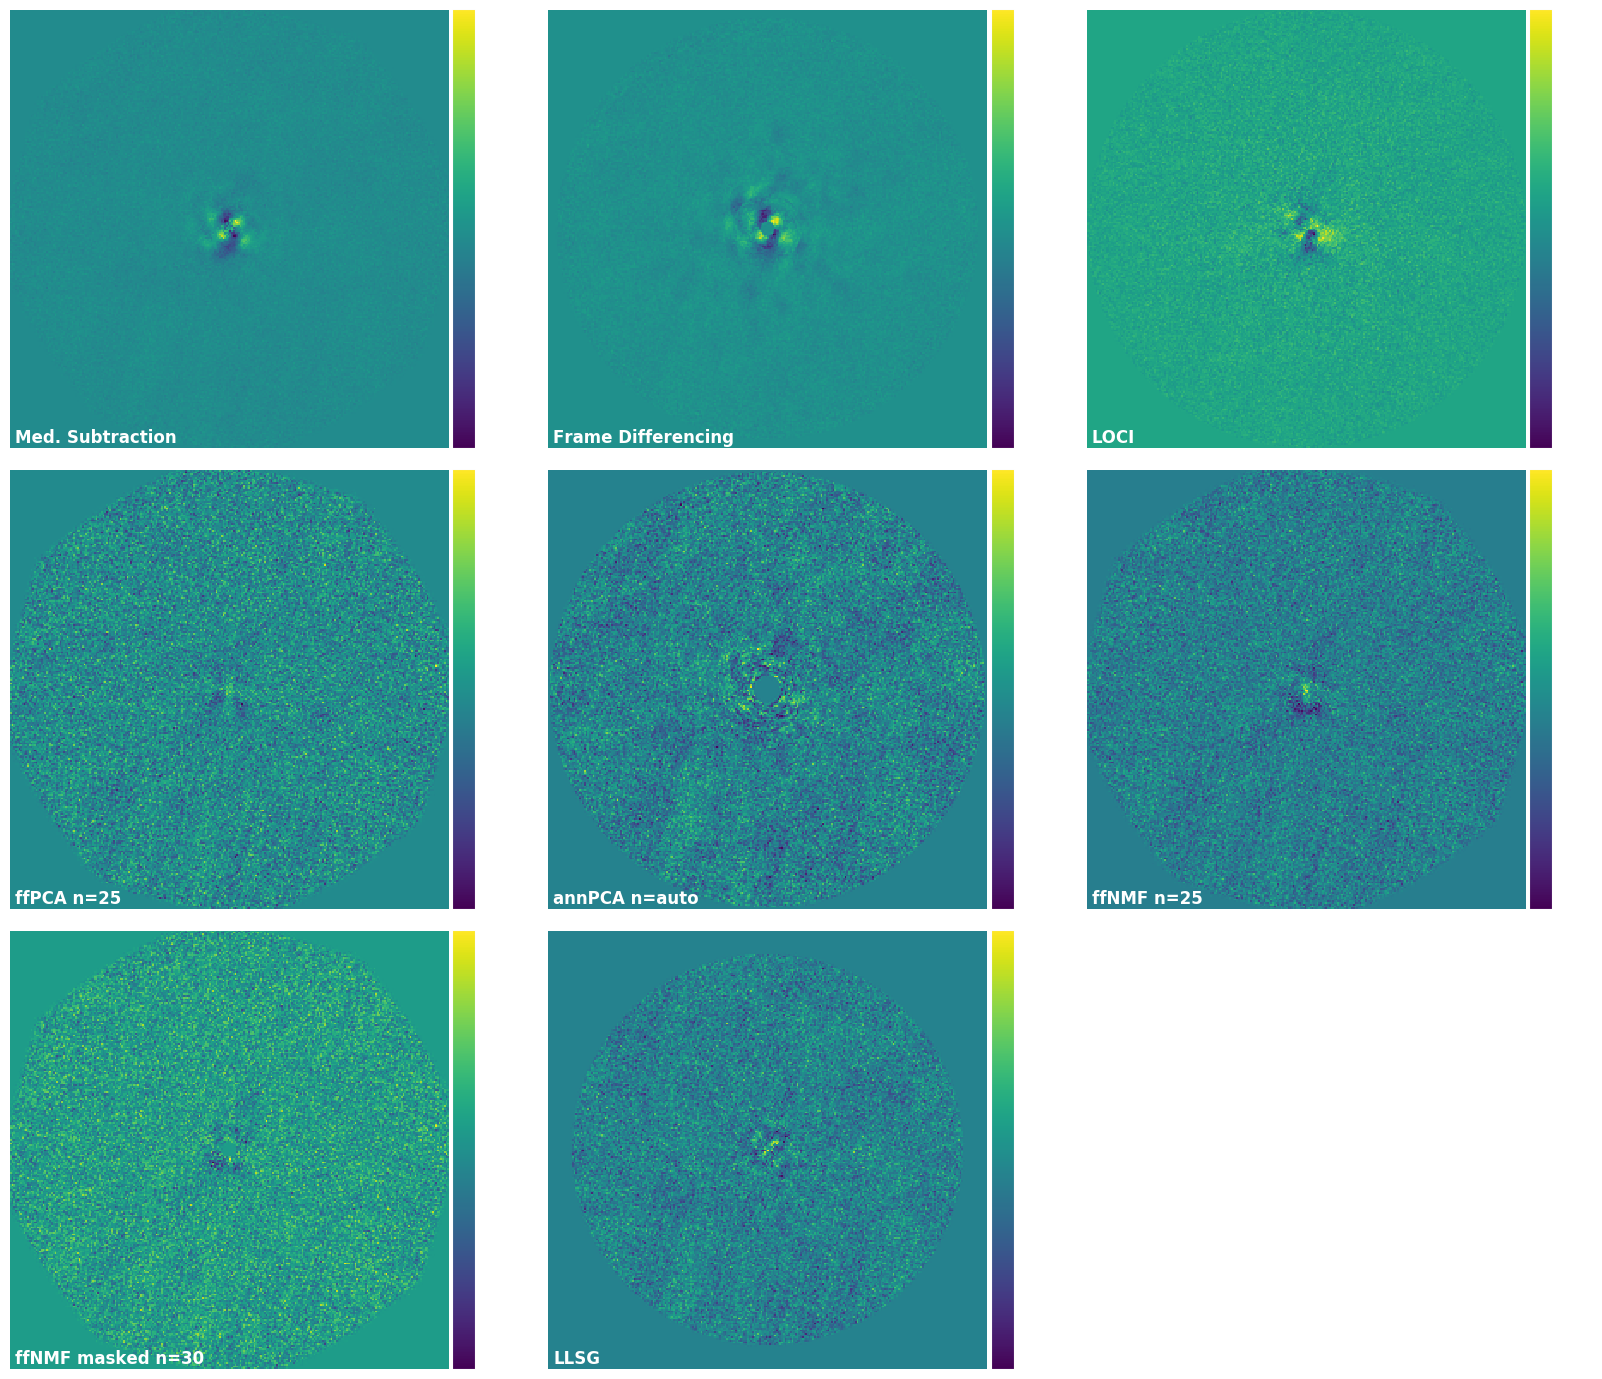

In [50]:
frames = {
    "Med. Subtraction": res_med,
    "Frame Differencing": res_frdiff,
    "LOCI": res_loci,
    "ffPCA n=25": res_pca[-1],
    "annPCA n=auto": fr_pca_auto,
    "ffNMF n=25": res_nmf[7],
    "ffNMF masked n=30": res_nmf_masked[2],
    "LLSG": res_llsg,
}

plot_frames(
    tuple(frames.values()),
    label=tuple(frames.keys()),
    rows=3,
    axis=False,
    horsp=0.1,
    versp=0.05,
)